In [172]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier, XGBRegressor

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn. neighbors import LocalOutlierFactor

from sklearn import svm
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score

from scipy.stats import expon, reciprocal

In [ ]:


def test_ensemble(X_train, y_train, X_test, y_test):
    clf1 = LogisticRegression(multi_class='multinomial', random_state=1)
    clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
    clf3 = GaussianNB()
    # X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
    # y = np.array([1, 1, 1, 2, 2, 2])

    eclf1 = VotingClassifier(estimators=[
             ('lr', clf1), ('rf', clf2), ('gnb', clf3)],
                             voting='hard')
    eclf1 = eclf1.fit(X_train, y_train)
    eclf1_pred = eclf1.predict(X_test)

    np.array_equal(eclf1.named_estimators_.lr.predict(X_test),
                    eclf1.named_estimators_['lr'].predict(X_test))

    eclf2 = VotingClassifier(estimators=[
             ('lr', clf1), ('rf', clf2), ('gnb', clf3)],
             voting='soft')
    eclf2 = eclf2.fit(X_train, y_train)
    eclf2_pred = eclf2.predict(X_test)


    eclf3 = VotingClassifier(estimators=[
            ('lr', clf1), ('rf', clf2), ('gnb', clf3)],
            voting='soft', weights=[2,1,1],
            flatten_transform=True)
    eclf3 = eclf3.fit(X_train, y_train)
    eclf3_pred = eclf3.predict(X_test)
    #print(eclf3.transform(X_test).shape)
    
    return accuracy_score(y_test, eclf1_pred), accuracy_score(y_test, eclf2_pred), accuracy_score(y_test, eclf3_pred)

In [9]:
df = pd.read_csv('./data/galaxy.csv')
df_cleaned = pd.read_csv('./data/galaxy-cleaned.csv', index_col=0)
df_cleaned_scaled = pd.read_csv('./data/galaxy-cleaned-scaled.csv', index_col=0)
df_lof2 = pd.read_csv('./data/galaxy_lof.csv', index_col=0)

X2 = df_lof2.drop('sold', axis=1)
y2 = df_lof2.sold
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=11)

In [10]:
df_cleaned.head()

,BuyItNow,startprice,hasDescription,upperCaseDescription,sold,has_carrier,has_color,has_productline,modelNumber,isNote
0,0,199.99,0,0,1,1,1,1,3,0
1,0,235.00,0,0,0,1,0,1,3,1
2,0,199.99,1,1,0,0,0,0,2,0
3,1,175.00,0,0,1,1,1,1,3,1
4,1,100.00,0,0,1,1,1,1,2,0


In [11]:
df.groupby('productline')['startprice'].mean().sort_values(ascending=False)

productline
Galaxy_Note10    366.931311
Galaxy_S10       294.583750
Galaxy_Note9     254.561402
Galaxy_S9        231.268101
Galaxy_Note8     176.065033
Unknown          171.994265
Galaxy_S8        165.883321
Galaxy_S7         84.190000
Name: startprice, dtype: float64

In [12]:
df['productline'] = df['productline'].apply(\
                                lambda x: re.sub('[^0-9]', '', x) if x.startswith('G') else '8')

In [13]:
df.groupby('productline')['startprice'].mean().sort_values(ascending=False)

productline
10    365.319109
9     240.673321
8     170.306719
7      84.190000
Name: startprice, dtype: float64

In [14]:
df.groupby('productline')['startprice'].count().sort_values(ascending=False)

productline
8     634
10    359
9     265
7     227
Name: startprice, dtype: int64

In [15]:
df = df.drop(['carrier', 'color', 'noDescription', 'charCountDescription', 'upperCaseDescription'],
       axis=1)

# Find Outlier by Models

In [16]:
model7 = df['productline']=='7'
model8 = df['productline']=='8'
model9 = df['productline']=='9'
model10 = df['productline']=='10'

BIN0 = df['BuyItNow']==0
BIN1 = df['BuyItNow']==1

sold0 = df['sold'] == 0
sold1 = df['sold'] == 1

<AxesSubplot:xlabel='startprice', ylabel='Count'>

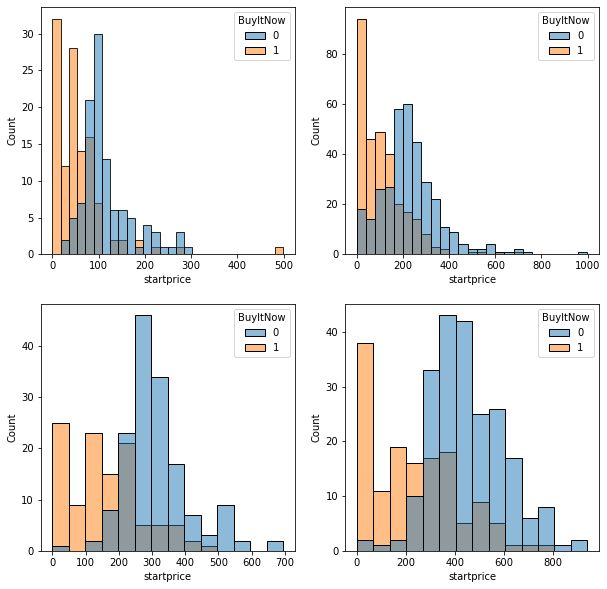

In [17]:
fig, axes = plt.subplots(2,2, figsize=(10, 10))
fig.figsize=(20,20)
sns.histplot(x=df[model7]['startprice'], data=df[model7],
            hue='BuyItNow', ax=axes[0][0])
sns.histplot(x=df[model8]['startprice'], data=df[model8],
            hue='BuyItNow', ax=axes[0][1])
sns.histplot(x=df[model9]['startprice'], data=df[model9],
            hue='BuyItNow', ax=axes[1][0])
sns.histplot(x=df[model10]['startprice'], data=df[model10],
            hue='BuyItNow', ax=axes[1][1])

### Local Outlier Factor
- The number of neighbors considered (parameter n_neighbors) is typically set 
    - 1) greater than the minimum number of samples a cluster has to contain, so that other samples can be local outliers relative to this cluster
    - 2) smaller than the maximum number of close by samples that can potentially be local outliers. 
- In practice, such informations are generally not available, and taking n_neighbors=20 appears to work well in general.

In [20]:
clf = LocalOutlierFactor(n_neighbors=25)
y_pred = clf.fit_predict(df.drop('sold', axis=1))
lof_outlier_idx = pd.Series(y_pred)[pd.Series(y_pred)==-1].index
print(len(lof_outlier_idx))
df.iloc[lof_outlier_idx]

214


,BuyItNow,startprice,productline,sold
5,1,0.99,7,1
12,0,344.95,10,0
16,0,95.00,7,0
19,0,149.00,10,0
23,0,309.99,9,0
...,...,...,...,...
1438,1,0.99,9,1
1454,0,244.95,9,0
1456,0,289.00,8,0
1460,1,0.99,9,1


### sota!

In [21]:
clf = LocalOutlierFactor(n_neighbors=4, contamination=.1)
y_pred = clf.fit_predict(df.drop('sold', axis=1))
lof_outlier_idx2 = pd.Series(y_pred)[pd.Series(y_pred)==-1].index
print(len(lof_outlier_idx2))
df.iloc[lof_outlier_idx2]

149


,BuyItNow,startprice,productline,sold
6,1,150.00,9,1
10,0,75.00,7,1
27,0,299.98,10,0
58,0,79.99,7,1
61,0,279.99,10,0
...,...,...,...,...
1458,1,49.95,8,1
1465,1,52.25,8,0
1469,0,249.99,10,1
1480,0,89.50,7,0


# `df_lof`

In [22]:
df_lof = df.drop(lof_outlier_idx2)

In [23]:
model7 = df_lof['productline']=='7'
model8 = df_lof['productline']=='8'
model9 = df_lof['productline']=='9'
model10 = df_lof['productline']=='10'

BIN0 = df_lof['BuyItNow']==0
BIN1 = df_lof['BuyItNow']==1

sold0 = df_lof['sold'] == 0
sold1 = df_lof['sold'] == 1

<AxesSubplot:xlabel='startprice', ylabel='Count'>

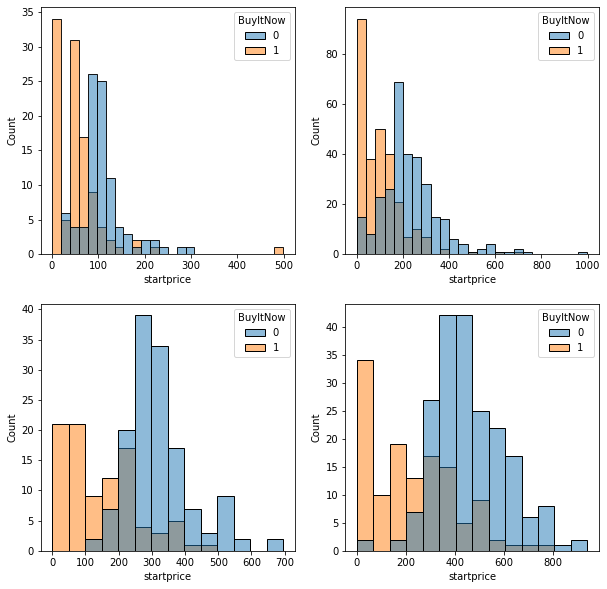

In [24]:
fig, axes = plt.subplots(2,2, figsize=(10, 10))
fig.figsize=(20,20)
sns.histplot(x=df_lof[model7]['startprice'], data=df_lof[model7],
            hue='BuyItNow', ax=axes[0][0])
sns.histplot(x=df_lof[model8]['startprice'], data=df_lof[model8],
            hue='BuyItNow', ax=axes[0][1])
sns.histplot(x=df_lof[model9]['startprice'], data=df_lof[model9],
            hue='BuyItNow', ax=axes[1][0])
sns.histplot(x=df_lof[model10]['startprice'], data=df_lof[model10],
            hue='BuyItNow', ax=axes[1][1])

<AxesSubplot:xlabel='startprice', ylabel='Count'>

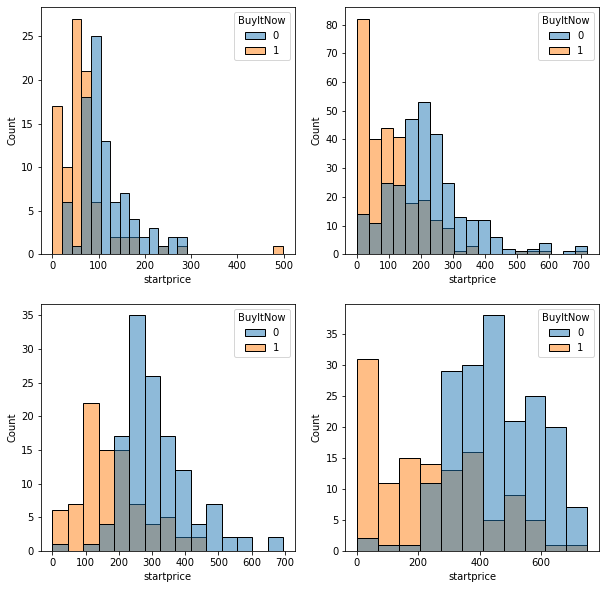

In [25]:
df_lof2 = df.drop(lof_outlier_idx)

model7 = df_lof2['productline']=='7'
model8 = df_lof2['productline']=='8'
model9 = df_lof2['productline']=='9'
model10 = df_lof2['productline']=='10'

BIN0 = df_lof2['BuyItNow']==0
BIN1 = df_lof2['BuyItNow']==1

sold0 = df_lof2['sold'] == 0
sold1 = df_lof2['sold'] == 1

fig, axes = plt.subplots(2,2, figsize=(10, 10))
fig.figsize=(20,20)
sns.histplot(x=df_lof2[model7]['startprice'], data=df_lof2[model7],
            hue='BuyItNow', ax=axes[0][0])
sns.histplot(x=df_lof2[model8]['startprice'], data=df_lof2[model8],
            hue='BuyItNow', ax=axes[0][1])
sns.histplot(x=df_lof2[model9]['startprice'], data=df_lof2[model9],
            hue='BuyItNow', ax=axes[1][0])
sns.histplot(x=df_lof2[model10]['startprice'], data=df_lof2[model10],
            hue='BuyItNow', ax=axes[1][1])

In [26]:
X = df.drop('sold', axis=1)
y = df.sold
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

In [27]:
X0 = df_cleaned.drop('sold', axis=1)
y0 = df_cleaned.sold
X0_train, X0_test, y0_train, y0_test = train_test_split(X0, y0, test_size=0.2, random_state=11)

In [28]:
X1 = df_lof.drop('sold', axis=1)
y1 = df_lof.sold
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=11)

In [29]:
X2 = df_lof2.drop('sold', axis=1)
y2 = df_lof2.sold
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=11)

In [30]:
lr = LogisticRegression(random_state=0)
lr.fit(X_train, y_train)
print(accuracy_score(y_test, lr.predict(X_test)))
print(test_ensemble(X_train, y_train, X_test, y_test))

0.7744107744107744
(0.7777777777777778, 0.7811447811447811, 0.7845117845117845)


In [31]:
lr = LogisticRegression(random_state=0)
lr.fit(X1_train, y1_train)
print(accuracy_score(y1_test, lr.predict(X1_test)))
print(test_ensemble(X1_train, y1_train, X1_test, y1_test))

0.832089552238806
(0.832089552238806, 0.8134328358208955, 0.8208955223880597)


### Tuning for LOF

In [177]:
test_neighbors = np.linspace(1, 100, num=100).astype(int)
test_contams = np.linspace(0.01, 0.2, num=20)
best_params, best_acc, X2, y2 = 0, 0, 0, 0

## LOF + GridSearch 결합하기

In [183]:
def tune_lof_by_model(model):
    best_params, best_acc, X2, y2 = 0, 0, 0, 0
    for tn in test_neighbors:
        for tc in test_contams:
            clf = LocalOutlierFactor(n_neighbors=tn, contamination=tc)
            y_pred = clf.fit_predict(df.drop('sold', axis=1))
            lof_outlier_idx = pd.Series(y_pred)[pd.Series(y_pred)==-1].index
            df_lof2 = df.drop(lof_outlier_idx)
            
            X2 = df_lof2.drop('sold', axis=1)
            y2 = df_lof2.sold
            X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=11)

            mod = model
            mod.fit(X2_train, y2_train)
            mod_acc = accuracy_score(y2_test, mod.predict(X2_test))
            if best_acc < mod_acc:
                best_acc = mod_acc
                best_params = (tn, tc)
                X2 = X2
                y2 = y2
    return best_params, best_acc, X2, y2
        #print(accuracy_score(y2_test, lr.predict(X2_test)))
        #print(test_ensemble(X2_train, y2_train, X2_test, y2_test))

In [286]:
best_params, best_acc

((22, 0.19), 0.8464730290456431)

In [33]:
clf = LocalOutlierFactor(n_neighbors=22, contamination=0.19)
y_pred = clf.fit_predict(df.drop('sold', axis=1))
lof_outlier_idx = pd.Series(y_pred)[pd.Series(y_pred)==-1].index
df_lof2 = df.drop(lof_outlier_idx)
X2 = df_lof2.drop('sold', axis=1)
y2 = df_lof2.sold

In [35]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=11)

In [184]:
svc_lof_tune = tune_lof_by_model(svm.SVC(random_state=0))
svc_lof_tune[:2]

((3, 0.2), 0.7983193277310925)

In [185]:
rf_base = RandomForestClassifier(random_state=0, n_jobs=-1)
rf_lof_tune = tune_lof_by_model(rf_base)
rf_lof_tune[:2]

KeyboardInterrupt: 

### GridCV for LogReg

In [37]:
def test_grid(model, X_train, y_train, X_test, y_test, p):
    params = p
    model = model #RandomForestClassifier(random_state=0, n_jobs=-1)
    grid_cv = GridSearchCV(model, param_grid=params,
                           cv=StratifiedKFold(n_splits=5),
                           n_jobs=-1)
    grid_cv.fit(X_train, y_train)
    pred = grid_cv.best_estimator_.predict(X_test)
    accuracy = accuracy_score(y_test, pred)
    print(accuracy)
    return grid_cv

In [211]:
logreg_p = {"C":np.logspace(-3, 3, 30),
             "penalty":["l1","l2"],
           "solver":['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
           "tol":np.logspace(-6, 1, 30),
           "multi_class":['auto', 'ovr', 'multinomial']
           }
lr = LogisticRegression(multi_class='auto', random_state=0, n_jobs=-1)
logreg_grid = test_grid(lr, X1_train, y1_train, X1_test, y1_test, logreg_p)

0.8208955223880597


In [212]:
logreg_grid.best_params_

{'C': 0.0727895384398315,
 'penalty': 'l2',
 'solver': 'newton-cg',
 'tol': 3.2903445623126713}

In [39]:
logreg_p = {"C":np.logspace(-3, 3, 30),
             "penalty":["l1","l2"],
           "solver":['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
           "tol":np.logspace(-6, 1, 30),
           "multi_class":['auto', 'ovr', 'multinomial']
           }
lr = LogisticRegression(random_state=0, n_jobs=-1)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=11)

logreg_grid2 = test_grid(lr, X2_train, y2_train, X2_test, y2_test, logreg_p)

0.8340248962655602


/opt/anaconda3/envs/AI_dev/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


In [40]:
logreg_grid2.best_params_

{'C': 0.04520353656360243,
 'multi_class': 'auto',
 'penalty': 'l1',
 'solver': 'liblinear',
 'tol': 0.35622478902624444}

In [114]:
logreg_grid2.best_score_

0.7641407599309155

In [155]:
#df_lof2.to_csv('./data/galaxy_lof.csv', encoding='utf-8-sig')
df_lof2 = pd.read_csv('./data/galaxy_lof.csv', index_col=0)
X2 = df_lof2.drop('sold', axis=1)
y2 = df_lof2.sold
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=11)

# 
best_params_logreg = {'C': 0.04520353656360243,
                     'multi_class': 'auto',
                     'penalty': 'l1',
                     'solver': 'liblinear',
                    'tol': 0.35622478902624444,
                     'random_state':0}

best_logreg = LogisticRegression(C=0.04520353656360243,
                     multi_class='auto',
                     penalty='l1',
                     solver='liblinear',
                    tol = 0.35622478902624444,
                     random_state = 0)
best_logreg.fit(X2_train, y2_train)
accuracy_score(y2_test, best_logreg.predict(X2_test))

0.8340248962655602

In [156]:
f1_score(y2_test, best_logreg.predict(X2_test))

0.8130841121495327

### RandomForest GridSearch

In [56]:
def test_rf(X_train, y_train, X_test, y_test, p, cv_):
    params = p
    rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
    grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=cv_, n_jobs=-1)
    grid_cv.fit(X_train, y_train)

    pred = grid_cv.best_estimator_.predict(X_test)
    accuracy = accuracy_score(y_test, pred)
    print(accuracy)
    return grid_cv

def show_feature_importances(grid_cv):
    ftr_importances_values = grid_cv.best_estimator_.feature_importances_
    ftr_importances_values = pd.Series(ftr_importances_values, index=X_train.columns)

    ftr_top20 = ftr_importances_values.sort_values(ascending=False)[:20]
    plt.figure(figsize=(8,6))
    plt.title('feature importance top 20')
    sns.barplot(x=ftr_top20, y=ftr_top20.index)
    plt.show()

In [53]:
params = {
    'n_estimators':[50, 100, 150],
    'criterion':['gini', 'entropy'],
    'max_depth':[6, 8, 10, 12],
    'min_samples_leaf':[8, 12, 18],
    'min_samples_split':[8, 16, 20]
}

#X_rf_grid = test_rf(X_train, y_train, X_test, y_test, params)
#X1_rf_grid = test_rf(X1_train, y1_train, X1_test, y1_test, params)
X2_rf_grid = test_rf(X2_train, y2_train, X2_test, y2_test, params, 2)

0.8506224066390041


In [54]:
X2_rf_grid.best_params_

{'criterion': 'gini',
 'max_depth': 6,
 'min_samples_leaf': 8,
 'min_samples_split': 8,
 'n_estimators': 50}

In [113]:
X2_rf_grid.best_score_

0.7910602910602911

In [59]:
X2_rf_grid2 = test_rf(X2_train, y2_train, X2_test, y2_test,
                      params, StratifiedKFold(n_splits=5))

0.8423236514522822


In [58]:
X2_rf_grid2.best_params_

{'criterion': 'entropy',
 'max_depth': 8,
 'min_samples_leaf': 8,
 'min_samples_split': 20,
 'n_estimators': 100}

In [112]:
X2_rf_grid2.best_score_

0.7953259930915371

In [67]:
params2 = {
    'n_estimators':[50, 100, 150, 300, 500],
    'criterion':['gini', 'entropy'],
    'max_depth':[3, 6, 8, 10, 12],
    'min_samples_leaf':[4, 8, 12, 18],
    'min_samples_split':[4, 8, 16, 20]
}

X2_rf_grid3 = test_rf(X2_train, y2_train, X2_test, y2_test,
                      params2, StratifiedKFold(n_splits=5))

0.8423236514522822


In [68]:
X2_rf_grid3.best_params_

{'criterion': 'entropy',
 'max_depth': 8,
 'min_samples_leaf': 8,
 'min_samples_split': 20,
 'n_estimators': 100}

In [111]:
X2_rf_grid3.best_score_

0.7953259930915371

### SVM GridSearch
- [서포트 벡터 머신(SVM)의 사용자로서 꼭 알아야할 것들 - 매개변수 C와 gamma](https://bskyvision.com/163)
    - [SVM model selection – how to adjust all these knobs pt. 1](https://tomaszkacmajor.pl/index.php/2016/04/24/svm-model-selection/)
    - [SVM model selection – how to adjust all these knobs pt. 2](https://tomaszkacmajor.pl/index.php/2016/05/01/svm-model-selection2/)
    - [Data preprocessing for SVM classifier](https://tomaszkacmajor.pl/index.php/2016/04/24/data-preprocessing/)

In [62]:
from sklearn import svm
from scipy.stats import expon, reciprocal

def test_svm(X_train, y_train, X_test, y_test, p, cv_):
    params = p
    svm_clf = svm.SVC(random_state=0)
    grid_cv = GridSearchCV(svm_clf, param_grid=params, cv=cv_, n_jobs=-1)
    grid_cv.fit(X_train, y_train)
    pred = grid_cv.best_estimator_.predict(X_test)
    accuracy = accuracy_score(y_test, pred)
    print(accuracy)
    return grid_cv

In [63]:
svm_params = {'kernel': ['rbf'],
               'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
                'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}

X2_svm_grid = test_svm(X2_train, y2_train, X2_test, y2_test,
                      svm_params, StratifiedKFold(n_splits=5))

0.8215767634854771


In [110]:
X2_svm_grid.best_score_

0.7776338514680483

In [65]:
X2_svm_grid.best_params_

{'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}

In [85]:
svm_clf = svm.SVC(random_state=0, gamma=0.00001, C=10000)
svm_clf.fit(X2_train, y2_train)
accuracy_score(y2_test, svm_clf.predict(X2_test))

0.8423236514522822

In [86]:
svm_clf = svm.SVC(random_state=0, gamma=0.000005, C=50000)
svm_clf.fit(X2_train, y2_train)
accuracy_score(y2_test, svm_clf.predict(X2_test))

0.8464730290456431

In [105]:
svm_clf = svm.SVC(random_state=0, gamma=0.000005, C=100000)
svm_clf.fit(X2_train, y2_train)
accuracy_score(y2_test, svm_clf.predict(X2_test))

0.8464730290456431

In [84]:
svm_clf = svm.SVC(random_state=0, gamma=0.00005, C=150000)
svm_clf.fit(X2_train, y2_train)
accuracy_score(y2_test, svm_clf.predict(X2_test))

0.8257261410788381

In [106]:
svm_params2 = {'C':reciprocal(10000, 100000),
              'gamma': expon(scale=0.000005)}
#              'decision_function_shape':('ovo','ovr'),
#              'shrinking':(True,False)}
svm_clf = svm.SVC()
X2_svm_grid2 = RandomizedSearchCV(svm_clf, param_distributions=svm_params2,
                                 n_iter=100, cv=StratifiedKFold(n_splits=5),
                                 verbose=3,
                                 random_state=0, n_jobs=-1)
X2_svm_grid2.fit(X2_train, y2_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  8.4min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   error_score=nan,
                   estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                                 class_weight=None, coef0=0.0,
                                 decision_function_shape='ovr', degree=3,
                                 gamma='scale', kernel='rbf', max_iter=-1,
                                 probability=False, random_state=None,
                                 shrinking=True, tol=0.001, verbose=False),
                   iid='deprecated', n_iter=100, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a3161a050>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a3161af50>},
                   pre_dispatch='2*n_jobs', random_state=0, refit=True,
                   return_train_score=False, scoring=None, verbose=3)

In [107]:
X2_svm_grid2.best_params_

{'C': 51789.45008120012, 'gamma': 3.382696867019862e-05}

In [109]:
X2_svm_grid2.best_score_

0.7703799654576856

In [108]:
pred = X2_svm_grid2.best_estimator_.predict(X2_test)
accuracy = accuracy_score(y2_test, pred)
print(accuracy)

0.8215767634854771


#### SVM Regressor + RandomizedSearchCV

In [73]:
from scipy.stats import expon, reciprocal

In [165]:
svm_params3 = {'C':reciprocal(10000, 100000),
              'gamma': expon(scale=0.000005)}
#              'decision_function_shape':('ovo','ovr'),
#              'shrinking':(True,False)}
svm_reg = svm.SVR()
X2_svm_grid3 = RandomizedSearchCV(svm_reg, param_distributions=svm_params3,
                                 n_iter=100, cv=StratifiedKFold(n_splits=5),
                                 verbose=3,
                                 random_state=0, n_jobs=-1)
X2_svm_grid3.fit(X2_train, y2_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [162]:
X2_svm_grid3.best_params_, X2_svm_grid3.best_score_

({'C': 11777.03750752171, 'gamma': 4.5580514559500244e-07},
 -0.17477554860645597)

In [164]:
pred = X2_svm_grid3.best_estimator_.predict(X2_test)
pred

array([ 0.81133482,  0.12635119,  0.08462037,  1.09818472,  0.74822543,
        0.21221419,  0.88827096,  0.78386448,  0.10732373,  1.02811376,
        0.04489984,  0.96482006,  0.10150522,  0.15209422,  0.77524967,
        0.10150522,  0.71104713,  0.74822543,  0.62084877,  0.03820819,
        0.28122901,  0.06129131,  0.10562233,  0.90807851,  0.84015291,
        0.09931129,  0.02474445,  0.15208037,  1.06516776,  0.09524654,
        0.10723697,  0.2286928 ,  0.132003  ,  0.59797305,  0.09815253,
        0.0785994 ,  0.99517153,  0.82952538,  0.37788066,  0.08765104,
        1.09816467,  0.08395968,  1.02811376,  0.8911019 ,  0.01468179,
        0.79723414,  0.10280375,  0.10077209,  0.14702168,  0.89006183,
        0.74793592,  0.24913921,  0.67406597,  1.02811376,  0.09310451,
        0.97374785,  0.1007721 ,  0.21221419,  0.08533499,  1.02811376,
        0.53869226,  0.63234614,  0.28303877,  0.11151083,  0.92754545,
        0.83778595,  0.05181945,  0.63234614,  0.71273126,  0.09

In [170]:
pred_converted = pd.Series(pred).apply(lambda x: 1 if abs(x-1)<x else 0)

In [171]:
accuracy = accuracy_score(y2_test, pred_converted)
print(accuracy)

0.8340248962655602


### Light GBM
설명 및 사용법 https://greeksharifa.github.io/machine_learning/2019/12/09/Light-GBM/

In [117]:
from lightgbm import LGBMClassifier

In [124]:
lgbm = LGBMClassifier(n_estimators=2)
lgbm.fit(X2_train, y2_train)
accuracy_score(y2_test, lgbm.predict(X2_test))

0.8547717842323651

In [135]:
params = {'max_depth': [3, 5, 10, 20],
          'num_leaves':[2**2, 2**4, 2**9],
          'min_child_samples': [30, 60, 120, 240, 480, 960],
          'subsample': [0.25, 0.5, 0.75, 1],
         'learning_rate':[0.001, 0.01, 0.1],
         'n_estimators':[32, 128, 256, 512, 1024]}

lgbm = LGBMClassifier()
grid = GridSearchCV(lgbm, param_grid=params)
grid.fit(X2_train, y2_train)

#print("최적 파라미터: ", grid.best_params_)
#lgbm_roc_score = roc_auc_score(y2_test, grid.predict_proba(X2_test)[:, 1], average='macro')
#print("ROC AUC: {0:.4f}".format(lgbm_roc_score))

GridSearchCV(cv=None, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=None, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=...
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='deprecated', n_jobs=None,
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'max_d

In [136]:
grid.best_params_

{'learning_rate': 0.01,
 'max_depth': 3,
 'min_child_samples': 60,
 'n_estimators': 1024,
 'num_leaves': 16,
 'subsample': 0.25}

In [137]:
grid.best_score_

0.7911539291882556

In [143]:
# 위 결과를 적용하여 재학습
lgbm = LGBMClassifier(n_estimators=1024, num_leaves=16, subsample=0.25,
                      min_child_samples=60, max_depth=3, learning_rate=0.01)

evals = [(X2_test, y2_test)]
#lgbm.fit(X2_train, y2_train, early_stopping_rounds=100, eval_metric='auc',
#         eval_set=evals)
lgbm.fit(X2_train, y2_train)
print(accuracy_score(y2_test, lgbm.predict(X2_test)))
#score = roc_auc_score(y2_test, grid.predict_proba(X2_test)[:, 1], average='macro')
#print("ROC AUC: {0:.4f}".format(score))

0.8464730290456431


### XGBoost

In [ ]:
param_grid = {'learning_rate': [0.05, 0.10, 0.15, 0.20, 0.25, 0.30] ,
            'max_depth'        : [3, 4, 5, 6, 8, 10, 12, 15],
            'min_child_weight' : [1, 3, 5, 7],
            'gamma'            : [0.0, 0.1, 0.2 , 0.3, 0.4],
            'colsample_bytree' : [0.3, 0.4, 0.5 , 0.7],
            'n_estimators':[100, 300, 500, 700, 1000]
             }

xgboost_reg = XGBRegressor(n_jobs=-1, random_state=0)
grid_search = GridSearchCV(xgboost_reg, param_grid,
                           cv=StratifiedKFold(n_splits=5),
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(my_data, my_labels, verbose=False)

### StackingClassifier
https://www.kaggle.com/kabirnagpal/feature-selection-and-stacking-f1-score-99
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html

```python
x_train, x_test, y_train, y_test =\
  train_test_split(cancer.data, cancer.target,
                   random_state=0, test_size=0.3, stratify=cancer.target)
```
- train_test_split, `stratify` 파라미터

In [144]:
from sklearn.ensemble import *
from sklearn.tree import *
from sklearn.feature_selection import *
from sklearn.preprocessing import *
from sklearn.model_selection import *
from sklearn.linear_model import *
from sklearn.naive_bayes import *
from sklearn.svm import *
from sklearn.neighbors import *
from sklearn.tree import *
from sklearn.metrics import *
import time
import warnings

In [145]:
classifiers = [
    KNeighborsClassifier(5),
    SVC(kernel="rbf"),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GaussianNB(),
    RidgeClassifier(),
    LogisticRegression(max_iter=200)
]
def f_score(X_train, X_test, y_train, y_test):
    for clf in classifiers:
        s = time.time()
        clf.fit(X_train,y_train)
        y_pred = clf.predict(X_test)
        f = f1_score(y_true=y_test,y_pred=y_pred,average="macro")
        e = time.time()
        print(f"Score: {round(f,3)} \t Time(in secs): {round(e-s,3)} \t Classifier: {clf.__class__.__name__}")
    

In [146]:
f_score(X2_train, X2_test, y2_train, y2_test)

Score: 0.705 	 Time(in secs): 0.018 	 Classifier: KNeighborsClassifier
Score: 0.715 	 Time(in secs): 0.022 	 Classifier: SVC
Score: 0.727 	 Time(in secs): 0.004 	 Classifier: DecisionTreeClassifier
Score: 0.724 	 Time(in secs): 0.151 	 Classifier: RandomForestClassifier
Score: 0.832 	 Time(in secs): 0.003 	 Classifier: GaussianNB
Score: 0.845 	 Time(in secs): 0.028 	 Classifier: RidgeClassifier
Score: 0.845 	 Time(in secs): 0.015 	 Classifier: LogisticRegression


In [153]:
estimators = [
#        ('RFC' ,RandomForestClassifier(n_estimators=500, random_state = 42)),
#        ('KNC', KNeighborsClassifier(5)),
#        ('DTC', DecisionTreeClassifier()),
#        ('SVC', SVC(kernel="rbf")),
        ('GNB', GaussianNB()),
        ('RC',  RidgeClassifier()),
        ('LR', LogisticRegression(max_iter=200))
]

clf = StackingClassifier(
    estimators=estimators, 
    final_estimator=GradientBoostingClassifier()
)

In [154]:
s = time.time()
clf.fit(X2_train,y2_train)
y_pred = clf.predict(X2_test)
e = time.time()
print(f"time consumed: {round(e-s,3)}")
print(accuracy_score(y2_test, y_pred))
print(f1_score(y_true=y2_test,y_pred=y_pred,average="macro"))


time consumed: 0.24
0.8049792531120332
0.8014792225318542


In [ ]:
s = time.time()
clf.fit(x,y)
y_pred = clf.predict(df_test_x)
e = time.time()
print(f"time consumed: {round(e-s,3)}")
f1_score(y_true=df_test_y,y_pred=y_pred,average="macro")

# Error Analysis

In [213]:
def result_df(grid_cv_fit, X, y):
    
    X_pred = pd.DataFrame(grid_cv_fit.predict(X),
                          columns=['sold_pred'])
    X_pred_proba = pd.DataFrame(grid_cv_fit.predict_proba(X),
                                columns=['sold0_proba', 'sold1_proba'])
    y = pd.DataFrame(y, columns=['sold'])
    
    res_df = pd.concat([X, y, X_pred, X_pred_proba], axis=1)
    res_df['wrong_pred'] = res_df['sold'] != res_df['sold_pred']
    
    return res_df

In [222]:
confusion_matrix(y1_test, logreg_grid.predict(X1_test))

array([[120,  17],
       [ 31, 100]])

In [221]:
pd.Series(logreg_grid.predict(X1)).value_counts()

0    760
1    576
dtype: int64

In [216]:
result_df(logreg_grid, X1, y1)

,BuyItNow,startprice,productline,sold,sold_pred,sold0_proba,sold1_proba,wrong_pred
0,0.0,199.99,9,1.0,0.0,0.617393,0.382607,True
1,0.0,235.00,9,0.0,0.0,0.672549,0.327451,False
2,0.0,199.99,8,0.0,0.0,0.691982,0.308018,False
3,1.0,175.00,9,1.0,1.0,0.292842,0.707158,False
4,1.0,100.00,8,1.0,1.0,0.255878,0.744122,False
...,...,...,...,...,...,...,...,...
1478,0.0,319.00,8,0.0,NaN,NaN,NaN,True
1479,0.0,424.99,10,1.0,NaN,NaN,NaN,True
1481,0.0,239.95,9,1.0,NaN,NaN,NaN,True
1482,0.0,329.99,10,0.0,NaN,NaN,NaN,True


# 차원의 저주와 싸우기
1. [차원축소-PCA](https://excelsior-cjh.tistory.com/167)
    - [차원축소-LLE](https://excelsior-cjh.tistory.com/168?category=918734)
    - [SVM](https://excelsior-cjh.tistory.com/66?category=918734)
3. [핸즈온 머신러닝 차원축소](https://hoony-gunputer.tistory.com/entry/핸즈온-머신러닝8강-차원축소-2편)

### PCA

In [139]:
from sklearn.decomposition import PCA, KernelPCA

In [155]:
pca = PCA(n_components=3)
pca.fit(df) # df
pca.explained_variance_ratio_

array([9.99962374e-01, 2.54005566e-05, 8.40860825e-06])

In [165]:
pca = PCA(n_components=5)
pca.fit(df_cleaned) # df
pca.explained_variance_ratio_

array([9.99922157e-01, 2.85947233e-05, 1.61500802e-05, 9.13356157e-06,
       7.80591226e-06])

In [166]:
df_original = pd.read_csv('./data/galaxy.csv')

In [167]:
rbf_pca = KernelPCA(n_components=1, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(df.drop('sold', axis=1))

In [150]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
    ("kpca", KernelPCA(n_components=2)),
    ("log_reg", LogisticRegression())
])

param_grid = [{
    "kpca_gamma":np.linspace(0.03, 0.05, 10),
    "kpca_kernel":["rbf", "sigmoid"]
},
{'random_state':[0, 1]}]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X1_train,y1_train)

ValueError: Invalid parameter kpca_gamma for estimator Pipeline(memory=None,
         steps=[('kpca',
                 KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=3,
                           eigen_solver='auto', fit_inverse_transform=False,
                           gamma=None, kernel='linear', kernel_params=None,
                           max_iter=None, n_components=2, n_jobs=None,
                           random_state=None, remove_zero_eig=False, tol=0)),
                ('log_reg',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False). Check the list of available parameters with `estimator.get_params().keys()`.

# Locally Linear Embedding
출처: https://excelsior-cjh.tistory.com/168?category=918734 [EXCELSIOR]

In [186]:
from sklearn.manifold import LocallyLinearEmbedding

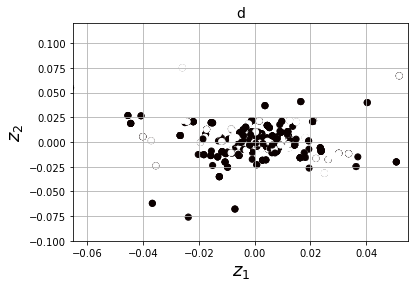

In [195]:
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=2, random_state=42, eigen_solver='dense')
lle.fit(X1)
X1_reduced = lle.transform(X1)
plt.title("d", fontsize=14)
plt.scatter(X1_reduced[:, 0], X1_reduced[:, 1], c=y1, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)
plt.show()

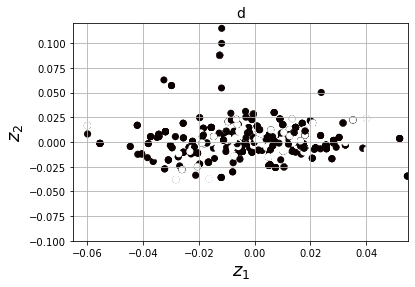

In [196]:
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=2, random_state=42, eigen_solver='dense')
lle.fit(X0)
X0_reduced = lle.transform(X0)
plt.title("d", fontsize=14)
plt.scatter(X0_reduced[:, 0], X0_reduced[:, 1], c=y0, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)
plt.show()

# SVM


In [43]:
from sklearn import svm

In [44]:
svm_clf = svm.SVC(kernel='rbf')
svm_clf.fit(X2_train, y2_train)
accuracy_score(y2_test, svm_clf.predict(X2_test))

0.7261410788381742

In [194]:
svm_clf = svm.SVC(kernel='rbf')
svm_clf.fit(X1_train, y1_train)
accuracy_score(y1_test, svm_clf.predict(X1_test))

0.7052238805970149

In [197]:
X1_rdc_train, X1_rdc_test, y1_rdc_train, y1_rdc_test = train_test_split(
                                        X1_reduced, y1, test_size=0.2, random_state=11)

svm_clf = svm.SVC(kernel='rbf')
svm_clf.fit(X1_rdc_train, y1_rdc_train)
accuracy_score(y1_rdc_test, svm_clf.predict(X1_rdc_test))

0.5335820895522388

In [191]:
svm_clf = svm.SVC()
svm_clf.fit(X0_train, y0_train)
accuracy_score(y0_test, svm_clf.predict(X0_test))

0.7104377104377104

In [137]:
svm_clf = svm.SVC()
svm_clf.fit(X_train, y_train)
accuracy_score(y_test, svm_clf.predict(X_test))

0.7104377104377104

# DF2

In [7]:
df2 = df_cleaned.copy()
df2 = df2.drop(['hasDescription', 'upperCaseDescription', 'has_carrier', 'has_color', 'has_productline'],
              axis=1)

In [8]:
df2.head()

,BuyItNow,startprice,sold,modelNumber,isNote
0,0,199.99,1,3,0
1,0,235.00,0,3,1
2,0,199.99,0,2,0
3,1,175.00,1,3,1
4,1,100.00,1,2,0


In [ ]:
df2.groupby()